# Part 0: Requirements

In [1]:
# Allow python to import modules from src folders
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import defaultdict
import ast
from collections import Counter
sys.path.append("src/")

from preprocessing.load_dataset import *

SAVE_PATH = "./data/refined"
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

## Download data  
Please uncomment the following line to download data

In [2]:
# %run src/preprocessing/download_dataset.py

# Part I: Load, explore and join datasets

## CMU dataset

We load the 4 `.tsv` and `.txt` files of the CMU dataset into 4 different dataframes

In [3]:
characters_df = load_characters_df()
movies_df = load_movies_df()
plot_df = load_plot_df()
tvtropes_df = load_tvtropes_df()

### Characters

The characters dataframe comes from the CMU movies dataset. This dataframe describes movie characters and provides information about the actor who played the corresponding character. Here is a sample of this dataframe :

In [4]:
characters_df.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
429394,25752302,/m/09v2vpd,2009,NaN,1973-09-19,M,NaN,NaN,Jeremy Lindsay Taylor,35.0,/m/0ggfhfs,NaN,/m/02w8zcj
318241,20889546,/m/05b2p64,1975-11-06,Willy Clark,1920-10-01,M,1.892,/m/041rx,Walter Matthau,55.0,/m/02vbdgc,/m/04kpygp,/m/0gyy0
96154,1456002,/m/052zqs,1947-12-25,NaN,1904-09-17,M,NaN,NaN,Jerry Colonna,43.0,/m/0cw0fbg,NaN,/m/01vgx3r
179824,4500801,/m/0c5rx_,1987,NaN,NaN,NaN,NaN,NaN,Charlie Phillips,NaN,/m/0gcbwl5,NaN,/m/0gcbwl7
393791,24703493,/m/080hwn5,2000-09-26,NaN,1957,M,NaN,NaN,Dito Tsintsadze,43.0,/m/0bfmxzt,NaN,/m/080lqx5


In [5]:
total_characters = len(characters_df)
print(f"Number of characters loaded: {total_characters}")
print(f"Number of unique movies: {len(characters_df['wiki_movie_id'].unique())}")
print(f"Number of unique actors: {len(characters_df['freebase_actor_id'].unique())}", end="\n\n")

print(f"Percentage of missing gender: {characters_df['actor_gender'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing height: {characters_df['actor_height'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing ethnicity: {characters_df['actor_ethnicity'].isna().sum()/total_characters*100:.2f}%")
print(f"Percentage of missing age upon release: {characters_df['release_actor_age'].isna().sum()/total_characters*100:.2f}%")

Number of characters loaded: 450669
Number of unique movies: 64330
Number of unique actors: 135761

Percentage of missing gender: 10.12%
Percentage of missing height: 65.65%
Percentage of missing ethnicity: 76.47%
Percentage of missing age upon release: 35.08%


In [6]:
print(f"Number of character records for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()])}")
print(f"Number of unique actors for which ethnicity is known: {len(characters_df[~characters_df['actor_ethnicity'].isna()]['freebase_actor_id'].unique())}")

Number of character records for which ethnicity is known: 106058


Number of unique actors for which ethnicity is known: 8151


We can first notice that a great percentage of actor's ethnicity is missing. This may become a problem when we study the impact of actors' ethnicity on the success of a movie.

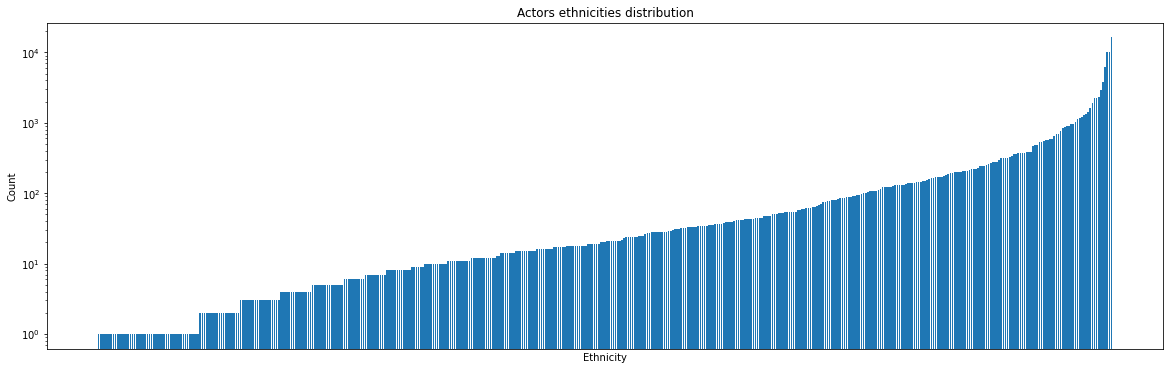

In [7]:
actors_ethnicities = characters_df[['freebase_actor_id', 'actor_ethnicity']].dropna().groupby(by='actor_ethnicity').count()
actors_ethnicities = actors_ethnicities.sort_values(by='freebase_actor_id')

plt.figure(figsize=(20,6))
plt.bar(actors_ethnicities.index, actors_ethnicities['freebase_actor_id'], label='')
plt.title("Actors ethnicities distribution")
plt.yscale('log')
plt.xticks([])
plt.ylabel("Count")
plt.xlabel("Ethnicity")
plt.show()

As shown, the ethnicities distribution is very heterogeneous. Some ethnicities have only one representative whereas others have more than thousands elements. During analysis, we must be careful on our conclusions as variance gets higher for the ethnicities with fewer representatives. Fortunately, we can quantify uncertainty in our results using tools like p-value and confidence interval.

### Movies

The movies dataframe also comes from the CMU dataset and provides information about movies such as its origins, runtime and box office.

In [8]:
movies_df.sample(5)

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres
16280,448331,/m/029p20,Class Action,1991-03-15,28277918.0,110.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/05bh16v': 'Courtro..."
45226,31818034,/m/0gtwg66,Gabhroo Punjab Da,1986,NaN,NaN,{'/m/0688f': 'Punjabi language'},{'/m/03rk0': 'India'},{'/m/02kdv5l': 'Action'}
54297,28492520,/m/0crbvk9,Servantes iz Malog Mista,1982,NaN,106.0,"{'/m/0k0sv': 'Croatian language', '/m/0k0sb': ...",{'/m/087vz': 'Yugoslavia'},{'/m/05p553': 'Comedy film'}
15341,25526521,/m/09rwjll,I Ought to Be in Pictures,1982-03-26,6968359.0,107.0,"{'/m/02h40lc': 'English Language', '/m/06nm1':...",{'/m/09c7w0': 'United States of America'},"{'/m/07s9rl0': 'Drama', '/m/01z4y': 'Comedy'}"
56105,5794209,/m/0f4yp_,Green Hell,1940,NaN,87.0,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/02kdv5l': 'Action', '/m/03k9fj': 'Adventu..."


In [9]:
total_movies = len(movies_df)
print(f"Number of movies loaded: {total_movies}")
print(f"Percentage of missing box office revenue: {movies_df['box_office'].isna().sum()/total_movies*100:.2f}%")

Number of movies loaded: 81741
Percentage of missing box office revenue: 89.72%


A great proportion of box office revenue data is missing (almost 90%). This makes sense as lots of movies are not shown in cinemas such as TV movies, short movies. Indeed, to get a movie to the box office, one needs to work with studios or convince distributors to distribute the movie.

Thus, using box office as a way to measure a movie's success may be biased because we already filter a specific type of movie. Furthermore, box office does not necessarily reflect the quality of a movie. Indeed some movies may not get a high box office revenue because of a lack of advertising. To fix this issue, we will use users rating from the IMDb database.

In [10]:
print(f"Number of movies for which we have matching character data: {len(movies_df.merge(characters_df, how='inner', on=['wiki_movie_id', 'freebase_movie_id'])['freebase_movie_id'].unique())}")

Number of movies for which we have matching character data: 64330


In [11]:
# Extract years from the release date of movies
movies_df['movie_release_year'] = movies_df[~movies_df['movie_release_date'].isna()]['movie_release_date'].astype(str).str[:4].astype(int)

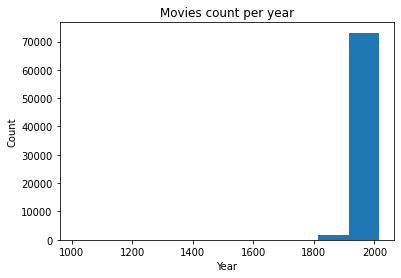

In [12]:
plt.hist(movies_df['movie_release_year'])
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

We notice that a movie has been produced before 1800 ! Let's investigate :

In [13]:
wrong_dates = movies_df[movies_df['movie_release_year'] < 1800].index
print(wrong_dates)

Int64Index([62836], dtype='int64')


In [14]:
movies_df.loc[wrong_dates]

,wiki_movie_id,freebase_movie_id,movie_name,movie_release_date,box_office,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{'/m/02hwyss': 'Turkish Language', '/m/02h40lc...",{'/m/01znc_': 'Turkey'},"{'/m/0lsxr': 'Crime Fiction', '/m/02n4kr': 'My...",1010.0


By googling the movie's name, we find that `Hunting season` should be released in 2010 (instead of 1010). This is obviously a typo and 1010 should be replaced by 2010.

In [15]:
# A movie that has the release date 1010. We fix the typo to 2010
movies_df.loc[wrong_dates, 'movie_release_year']= 2010
movies_df.loc[wrong_dates, 'movie_release_date'] ='2010-12-02'

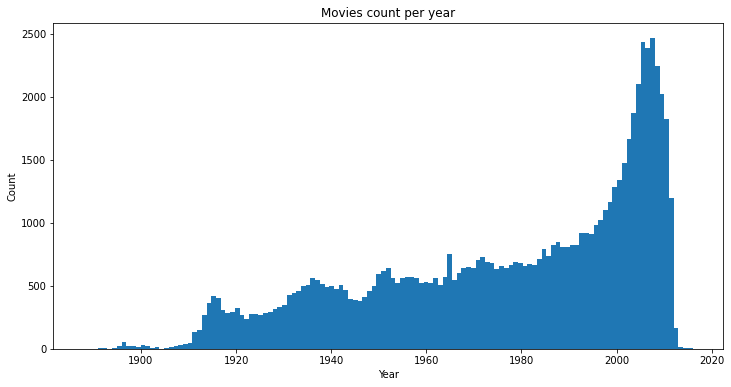

In [16]:
n_years = len(movies_df['movie_release_year'].dropna().unique())

plt.figure(figsize=(12, 6))
plt.hist(movies_df['movie_release_year'], bins=n_years)
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Movies count per year")
plt.show()

There are significantly more movies released after 1990 than before in our dataset.

### Plot

The plot dataframe comes from the CMU dataset and provides a summary of the plot of a given movie.

In [17]:
plot_df.sample(5)

,wiki_movie_id,plot_summary
28594,33408737,"Grace Roberts , marries rancher Edward Smith, ..."
38244,11760680,The movie is about a kid named Luke Malloy wh...
7961,19388734,Although this is a remake of a 1920's silent O...
13074,28869936,"The story begins in 1654, when northern China ..."
9090,16434354,The film follows 8 of the top high school bask...


In [18]:
total_plot = len(plot_df)
print(f"Number of plot summaries loaded: {total_plot}")

Number of plot summaries loaded: 42303


### Tropes

The tvtropes dataframe is the one used by the CMU researchers to validate their personas learning algorithm. Unfortunately, this dataset does not contain a lot of tvtropes and can not be used for our analysis. Thus we need other databases to get the persona of movie characters.

In [19]:
tvtropes_df.sample(5)

,trope_name,character_data
41,brainless_beauty,"{'char': 'Marcia Brady', 'movie': 'The Brady B..."
450,stupid_crooks,"{'char': 'Vinny', 'movie': 'Snatch', 'id': '/m..."
399,pupil_turned_to_evil,"{'char': 'Aaron Hallam', 'movie': 'The Hunted'..."
73,byronic_hero,"{'char': 'Captain Jack Sparrow', 'movie': 'Pir..."
490,warrior_poet,"{'char': 'Colonel Walter E. Kurtz', 'movie': '..."


In [20]:
total_tropes = len(tvtropes_df)
print(f"Number of tropes loaded: {total_tropes}")

Number of tropes loaded: 501


## IMDB dataset

We load the 4 `.tsv` files of the IMDB dataset into 4 different dataframes

In [21]:
imdb_ratings_df = load_imdb_ratings()
imdb_title_df = load_imdb_title_basics()
imdb_principals_df = load_imdb_title_principals()
imdb_people_df = load_imdb_person_basics()

### Ratings

In [22]:
imdb_ratings_df.sample(5)

,tconst,averageRating,numVotes
177334,tt0295452,6.6,133
627836,tt13339568,8.1,341
171548,tt0284334,6.9,938
1067298,tt3963170,4.3,333
458508,tt10112484,7.6,13


We have 1365868 movies for which we have a rating.


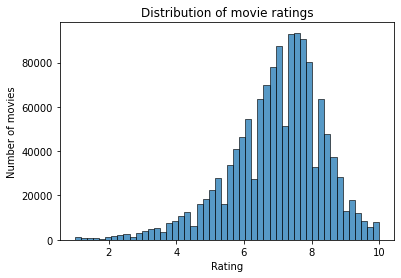

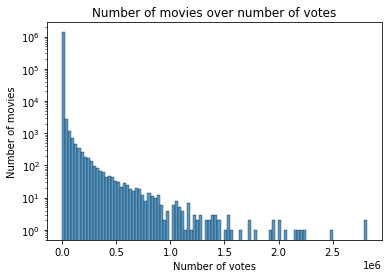

In [23]:
total_ratings = len(imdb_ratings_df)
print(f"We have {total_ratings} movies for which we have a rating.")

# Check the distribution of grades
sns.histplot(data=imdb_ratings_df, x="averageRating", bins=50)

plt.title("Distribution of movie ratings")
plt.xlabel("Rating")
plt.ylabel("Number of movies")
plt.show()

# Check the distribution of votes
sns.histplot(data=imdb_ratings_df, x="numVotes", bins=100)
plt.yscale("log")

plt.title("Number of movies over number of votes")
plt.xlabel("Number of votes")
plt.ylabel("Number of movies")
plt.show()

### Title

In [24]:
imdb_title_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
348656,tt0363914,movie,Pyaar Karke Dekho,Pyaar Karke Dekho,0,1987,\N,144,"Comedy,Drama,Family"
67381,tt0068760,movie,Jelbeszéd,Jelbeszéd,0,1974,\N,91,Drama
431792,tt0449823,movie,Autobus Nr. 2,Autobus Nr. 2,0,1929,\N,\N,\N
7759063,tt4325644,movie,Union,Union,0,2018,\N,135,"Drama,History,War"
2811101,tt13368232,movie,Holywood,Holywood,0,\N,\N,72,Documentary


In [25]:
# Remove adult content
imdb_title_df = imdb_title_df[imdb_title_df["isAdult"].astype(int) == 0]

In [26]:
total_title = len(imdb_title_df)
print(f"We have {total_title} movie titles")

We have 651888 movie titles


### Principals

In [27]:
imdb_principals_df.sample(5)

,tconst,ordering,nconst,category,job,characters
31761997,tt21249490,3,nm13835302,actress,\N,"[""Fuyumi Shiratori""]"
49135388,tt6333554,1,nm1736971,self,\N,"[""Self""]"
5034391,tt0678919,4,nm0090301,actress,\N,"[""Judy Bryant""]"
7434971,tt1000560,6,nm0240471,writer,creator,\N
34950290,tt2385336,3,nm0569156,actress,\N,"[""Lizzie Lakely""]"


In [28]:
total_principals = len(imdb_principals_df)
print(f"We have {total_principals} principals records")
print(f"We have {len(imdb_principals_df['category'].unique())} categories")
print(f"We have {len(imdb_principals_df['nconst'].unique())} unique persons")


We have 58900432 principals records
We have 12 categories
We have 5169350 unique persons


In [29]:
missing_characters = len(imdb_principals_df[imdb_principals_df['characters'] == "\\N"])
print(f"We have {missing_characters/total_principals*100:.2f}% of missing characters")

We have 51.88% of missing characters


### People

In [30]:
imdb_people_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
3817917,nm13057888,Mike Fan Yun-Fei,\N,\N,actor,tt15751210
4493437,nm13783240,Anshul Deshmukh,\N,\N,actor,tt21104324
9633355,nm5724056,Gordon Phillips,\N,\N,actor,tt2971372
8449826,nm4378786,Lauren Annis,\N,\N,actress,tt1841560
6827370,nm2535439,Shelby P. Lasalle Jr.,\N,\N,NaN,tt0199248


In [31]:
total_people = len(imdb_people_df)
print(f"We have {total_people} people records")
print(f"We have {len(imdb_people_df['nconst'].unique())} unique persons")
print(f"We have {len(imdb_people_df[imdb_people_df['primaryProfession'] == 'actor'])} unique actors")

We have 12978070 people records
We have 12978070 unique persons
We have 2343815 unique actors


### Movie titles with ratings

In [32]:
imdb_title_with_rating = imdb_title_df.merge(imdb_ratings_df, on='tconst', how='inner')
imdb_title_with_rating.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
281876,tt7812334,movie,Suicide the Ripple Effect,Suicide the Ripple Effect,0,2018,\N,93,Documentary,8.8,50
13614,tt0035916,movie,The Gang's All Here,The Gang's All Here,0,1943,\N,103,"Musical,Romance",6.6,2020
36258,tt0068524,movie,Man of the East,E poi lo chiamarono il magnifico,0,1972,\N,125,"Action,Comedy,Western",6.5,3116
145430,tt1031546,movie,Arini,Arini,0,1987,\N,103,Drama,8.7,20
22524,tt0048819,movie,Yo maté,Yo maté,0,1957,\N,72,"Crime,Drama",5.0,7


In [33]:
total_movies_w_rating = len(imdb_title_with_rating)
print(f"We have {total_movies_w_rating} movies with ratings")

We have 294744 movies with ratings


## Merge CMU movies and plot summaries with IMDB titles and ratings

The translation dataframe from wikidata, which includes both the IMDB id and the Freebase id, enables us to combine the IMDB dataset with the CMU dataset

In [34]:
translation_id = load_translation_df()

In [35]:
imdb_title_with_rating_translated = imdb_title_with_rating.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_title_with_rating_translated = imdb_title_with_rating_translated.drop(["imdb_id"], axis=1)

In [36]:
cmu_movies_w_imdb_rating = imdb_title_with_rating_translated.merge(movies_df, how='inner', left_on='freebase_id', right_on='freebase_movie_id').copy()

In [37]:
# IMDB start year has no missing data, so we insert it into "NaN" fields of "movie_release_date" and drop "startYear"
missing_years = cmu_movies_w_imdb_rating[cmu_movies_w_imdb_rating['movie_release_date'].isna()].index
cmu_movies_w_imdb_rating.loc[missing_years, 'movie_release_date'] = cmu_movies_w_imdb_rating.loc[missing_years, 'startYear']

In [38]:
# We have MANY depulicated attributes
# We evaluated for each pair which column had more missing data and dropped it in favor of the other
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop(["freebase_movie_id", "titleType", "isAdult", "endYear", "primaryTitle", "originalTitle", "movie_release_year", "movie_runtime", "startYear"], axis=1)

In [39]:
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.drop_duplicates("tconst")
print(f"The merged dataframe contains {len(cmu_movies_w_imdb_rating)} movies with corresponding ratings")

The merged dataframe contains 44467 movies with corresponding ratings


In [40]:
# Add summaries
cmu_movies_w_imdb_rating = cmu_movies_w_imdb_rating.merge(plot_df, on="wiki_movie_id", how="left")

In [41]:
cmu_movies_w_imdb_rating.sample(5)

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
18033,tt0078021,110,Drama,6.4,298,/m/06414kf,22876558,Blindfolded Eyes,1978-05-18,NaN,{'/m/06nm1': 'Spanish Language'},"{'/m/0f8l9c': 'France', '/m/06mkj': 'Spain'}",{'/m/07s9rl0': 'Drama'},Luis is a drama teacher producing a play abou...
43434,tt1817273,140,"Crime,Drama,Thriller",7.3,284195,/m/0gx999d,33572843,The Place Beyond the Pines,2012,NaN,{},{'/m/09c7w0': 'United States of America'},"{'/m/0lsxr': 'Crime Fiction', '/m/07s9rl0': 'D...",NaN
6707,tt0039009,74,"Adventure,Drama",6.2,199,/m/0crd8db,28350359,Tangier,1946-06-06,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01jfsb': 'Thriller', '/m/07s9rl0': 'Drama...",NaN
38152,tt0840406,93,Drama,6.2,297,/m/066196p,23248774,"War Eagle, Arkansas",2007,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/01z02hx': 'Sports', '/m/0hj3n84': 'Inspir...",NaN
30639,tt0239234,129,"Drama,History,Romance",6.8,2848,/m/0dfsb5,5326842,The Lady And The Duke,2001-09-07,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/03q4nz': 'World cinema', '/m/03g3w': 'His...",NaN


## Merge IMDB people and principals

In [42]:
titles_of_interest = cmu_movies_w_imdb_rating["tconst"].to_list()

In [43]:
imdb_actors = imdb_people_df[(imdb_people_df["primaryProfession"].str.contains("actor")) | (imdb_people_df["primaryProfession"].str.contains("actoress"))].copy()

In [44]:
imdb_principals_actors = imdb_principals_df[(imdb_principals_df["category"] == "actress") | (imdb_principals_df["category"] == "actor")].copy()

In [45]:
imdb_actors_and_characters = imdb_actors.merge(imdb_principals_actors, on="nconst", how="inner").copy()

In [46]:
imdb_actors_and_characters = imdb_actors_and_characters[imdb_actors_and_characters["tconst"].isin(titles_of_interest)]

In [47]:
imdb_actors_and_characters = imdb_actors_and_characters.drop(["ordering", "category", "job", "primaryProfession"], axis=1)

In [48]:
imdb_actors_and_characters.head(5)

,nconst,primaryName,birthYear,deathYear,knownForTitles,tconst,characters
0,nm0000001,Fred Astaire,1899,1987,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]"
1,nm0000001,Fred Astaire,1899,1987,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]"
2,nm0000001,Fred Astaire,1899,1987,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]"
3,nm0000001,Fred Astaire,1899,1987,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027630,"[""Bake Baker""]"
4,nm0000001,Fred Astaire,1899,1987,"tt0053137,tt0031983,tt0050419,tt0072308",tt0028333,"[""Lucky Garnett""]"


## Filter CMU characters

In [49]:
titles_of_interest_wiki = cmu_movies_w_imdb_rating["wiki_movie_id"].to_list()

In [50]:
characters_interest = characters_df[characters_df["wiki_movie_id"].isin(titles_of_interest_wiki)]

In [51]:
characters_interest.sample(5)

,wiki_movie_id,freebase_movie_id,release_date,character_name,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
42805,1755731,/m/05tgks,2002-12-13,Jerry Siegel,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,42.0,/m/09hyhzx,/m/0cj62hd,/m/02bj6k
220005,8900180,/m/027nw4c,1963,Moe,1897-06-19,M,1.620,NaN,Moe Howard,NaN,/m/0cgp1fz,/m/0h577m2,/m/02cvp8
166272,23173019,/m/064mdnk,2010,Gant Hoxey,1947-02-03,M,1.820,/m/02rbdlq,Stephen McHattie,62.0,/m/070536v,/m/0gbpnjz,/m/0fs9jn
219673,18148671,/m/04cv30w,1961,NaN,1928-10-01,M,NaN,NaN,Sivaji Ganesan,32.0,/m/0g9lrw_,NaN,/m/03hz1n
39164,3710183,/m/09wmnw,2003,Lee McCall,1966-01-31,M,1.680,NaN,Dexter Fletcher,36.0,/m/02vbhjq,/m/0lnnx4z,/m/03yb6y


## Merge IMDB actors and characters with CMU characters

In [52]:
imdb_actors_and_characters_translated = imdb_actors_and_characters.merge(translation_id, how='inner', left_on='tconst', right_on='imdb_id').copy()
imdb_actors_and_characters_translated = imdb_actors_and_characters_translated.drop(["imdb_id"], axis=1)

In [53]:
# TODO, currently merging on movie id and actor name. Would rather merge with actor id too but a translation is needed
imdb_actors_w_cmu_characters = imdb_actors_and_characters_translated.merge(characters_interest, how='inner', left_on=['freebase_id', 'primaryName'], right_on=['freebase_movie_id', 'actor_name']).copy()

# Merge birth year information
missing_birth_years = imdb_actors_w_cmu_characters[imdb_actors_w_cmu_characters['actor_birth'].isna()].index
imdb_actors_w_cmu_characters.loc[missing_birth_years, 'actor_birth'] = imdb_actors_w_cmu_characters.loc[missing_birth_years, 'birthYear']

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop(["freebase_movie_id", "primaryName", "deathYear", "birthYear", "character_name"], axis=1)

imdb_actors_w_cmu_characters = imdb_actors_w_cmu_characters.drop_duplicates()

imdb_actors_w_cmu_characters.sample(5)

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
37532,nm0006762,"tt0073341,tt0091578,tt0087892,tt0083987",tt0099429,"[""Mr. Mehra""]",/m/0ffwcz,5945470,1990-06-22,1929-01-08,M,NaN,/m/02sch9,Saeed Jaffrey,61.0,/m/02vblyy,/m/0h6dlbk,/m/05d7rk
8121,nm0195083,"tt0369880,tt8623376,tt0120866,tt0335345",tt0120866,"[""Clown""]",/m/03tsz3,963023,1999-12-26,1958,NaN,NaN,NaN,Dario D'Ambrosi,NaN,/m/0gcndzv,NaN,/m/0gcndzz
26157,nm0002064,"tt0903747,tt3040964,tt0097216,tt0114814",tt0120379,"[""Darryl""]",/m/0c028hf,27397030,1997,1958-04-26,M,1.715,/m/0xnvg,Giancarlo Esposito,38.0,/m/0g9fv96,/m/0g9fv79,/m/0807ml
13214,nm0000362,"tt0098621,tt0119488,tt0103776,tt0117008",tt0156323,"[""Grover Cleaver""]",/m/08dc1n,2929705,2000,1944-11-17,M,1.520,/m/0xnvg,Danny DeVito,55.0,/m/03lclmm,/m/0h12jm5,/m/0q9kd
56229,nm0280749,"tt0050762,tt0217026,tt0102247,tt0092987",tt0050762,"[""Jan Baalsrud""]",/m/07d6hx,2440669,1959-01-05,1915-03-24,M,NaN,NaN,Jack Fjeldstad,43.0,/m/0gb240d,NaN,/m/07kdgmg


## Summary of results for part I
We now have two main dataframes for further analysis. One containing everything related to movies and their ratings and the other containing everything related to actors, their features and characters they played in a given movie.

In [54]:
movies = cmu_movies_w_imdb_rating.copy()
actors_characters = imdb_actors_w_cmu_characters.copy()

In [55]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",NaN
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",NaN


In [56]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0036613,tt0030241,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,NaN,Edward Everett Horton,NaN,/m/0cs6brt,NaN,/m/0197p7
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0056412,tt0026942,tt0029284,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,NaN,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [57]:
movies.to_json(os.path.join(SAVE_PATH, "movies.json"), orient='records')

In [58]:
actors_characters.to_json(os.path.join(SAVE_PATH, "characters.json"), orient='records')

# Part II: Personas

In [59]:
# Load results of part I
movies = pd.read_json(os.path.join(SAVE_PATH, "movies.json"))
actors_characters = pd.read_json(os.path.join(SAVE_PATH, "characters.json"))

## TVTropes personas

In [60]:
tvtropes_personas = load_tv_tropes_personas_df()
tvtropes_personas.head()

,id,trope,actor,character,movie_name
0,/m/02wszk9,chanteuse,Kathleen Turner,Jessica Rabbit,Who Framed Roger Rabbit
1,/m/0k5wls,chanteuse,Cameron Diaz,Tina Carlyle,The Mask
2,/m/0k50tl,chanteuse,Michelle Pfeiffer,Susie Diamond,The Fabulous Baker Boys
3,/m/0k3j8v,chanteuse,Marilyn Monroe,Sugar Kane Kowalczyk,Some Like It Hot
4,/m/0jvlc4,chanteuse,Isabella Rossellini,Dorothy Vallens,Blue Velvet


### Analyse tropes per actor

In [61]:
tvtropes_per_actor = tvtropes_personas[["actor", "trope"]].copy().groupby("actor").agg(list).reset_index()

In [62]:
tvtropes_per_actor["num_tropes"] = tvtropes_per_actor["trope"].apply(lambda ls: len(list(dict.fromkeys(ls))))

In [63]:
tvtropes_per_actor = tvtropes_per_actor.sort_values("num_tropes")

In [64]:
tvtropes_per_actor.head()

,actor,trope,num_tropes
349,Zhang Ziyi,[arrogant_kungfu_guy],1
307,Shih Kien,[arrogant_kungfu_guy],1
179,Kenneth Branagh,[gadgeteer_genius],1
180,Kevin Costner,[young_gun],1
181,Kevin Gage,[psycho_for_hire],1


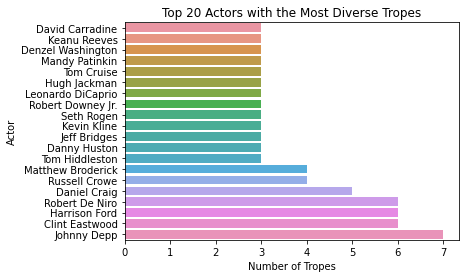

In [65]:
sns.barplot(data = tvtropes_per_actor.tail(20), x="num_tropes", y="actor", orient='h')
plt.xlabel('Number of Tropes')
plt.ylabel('Actor')
plt.title('Top 20 Actors with the Most Diverse Tropes')
plt.show()

### Analyse frequence of tropes when joined

In [66]:
tvtropes_personas_std = tvtropes_personas.copy()
tvtropes_personas_std['movie_name_standardized'] = tvtropes_personas_std['movie_name'].str.lower()

In [67]:
movies_std = movies.copy()
movies_std['movie_name_standardized'] = movies_std['movie_name'].str.lower()

In [68]:
movies_personas = movies_std.merge(tvtropes_personas_std, on='movie_name_standardized', how='inner')

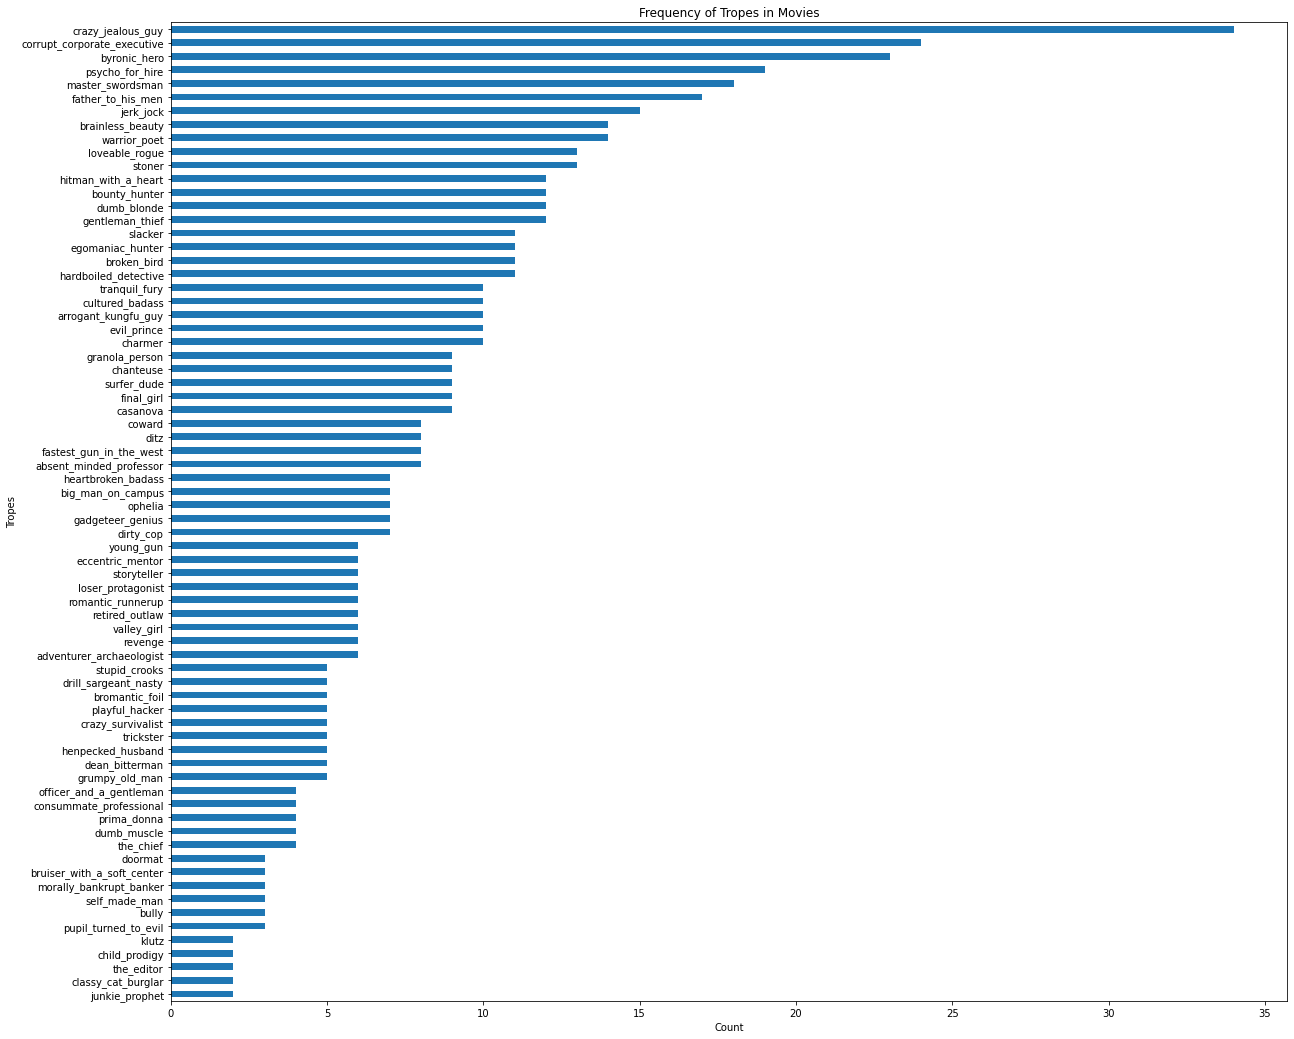

In [69]:
trope_value_counts = movies_personas['trope'].value_counts()

plt.figure(figsize=(20, 18))
trope_value_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Tropes')
plt.title('Frequency of Tropes in Movies')
plt.gca().invert_yaxis()
plt.show()

## CMU personas with characters

In [70]:
cmu_personas = load_personas()

In [71]:
cmu_personas.sample(5)

,freebase_id,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib
25448,e3,14330182,Dharm,boy,the boy,5,12,"[0.0, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
97332,e6,29198845,Morning Call,she,she,5,46,"[0.0, 0.07, 0.0, 0.02, 0.0, 0.01, 0.02, 0.0, 0..."
112561,e0,32995405,"All for Gold, or Jumping the Claim",he,his,4,3,"[0.0, 0.0, 0.08, 0.28, 0.0, 0.07, 0.04, 0.0, 0..."
23474,e20,1394167,100 Girls,Stern,Ms. Stern,3,49,"[0.0, 0.0, 0.22, 0.0, 0.0, 0.0, 0.03, 0.01, 0...."
62025,e22,2201333,Dust Devil: The Final Cut,he,he,9,35,"[0.0, 0.03, 0.0, 0.0, 0.0, 0.05, 0.0, 0.01, 0...."


In [72]:
movies_personas_cmu = cmu_personas.merge(actors_characters, left_on='freebase_id', right_on='freebase_map_id')

In [73]:
movies_personas_cmu.sample(5)

,freebase_id_x,wiki_id,movie_name,secondary_name,full_name,token_occurences,estimated_trope,trope_distrib,nconst,knownForTitles,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
1256,/m/040kcfq,13243296,Weirdsville,Dexter,Dexter,7,21,"[0.0, 0.02, 0.0, 0.0, 0.0, 0.02, 0.05, 0.0, 0....",nm0005454,"tt0482606,tt0320691,tt0401855,tt2355495",...,2007-01-19,1975-09-01,M,1.803,None,Scott Speedman,31.0,/m/040kcfq,/m/0h5h_s1,/m/06s9fb
1076,/m/03jsk35,12685170,Lars and the Real Girl,Gus,Gus and Karin,7,16,"[0.0, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",nm0773973,"tt0299458,tt0368709,tt0805564,tt0810784",...,2007-09-10,1976-03-16,M,1.800,None,Paul Schneider,31.0,/m/03jsk35,/m/0b3w8v8,/m/0dwmn3
9775,/m/0k30nh,612866,Secrets & Lies,Maurice Purley,Maurice stops her admiring,17,49,"[0.0, 0.0, 0.07, 0.0, 0.0, 0.02, 0.0, 0.0, 0.0...",nm0001758,"tt0408236,tt0259711,tt0117589,tt2473794",...,1996-05,1957-02-27,M,1.700,/m/02w7gg,Timothy Spall,NaN,/m/0k30nh,/m/0bnn1fs,/m/05kwx2
110,/m/0jwlz3,103011,Coming Home,Luke Martin,Luke,19,37,"[0.0, 0.0, 0.04, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",nm0000685,"tt0068473,tt0064665,tt0118615,tt0089941",...,1978-02-15,1938-12-29,M,1.892,/m/027n1m6,Jon Voight,39.0,/m/0jwlz3,/m/02nwcp4,/m/046qq
9157,/m/0jvmcp,540654,Body Heat,Ned Racine,Ned,41,41,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",nm0000458,"tt0120738,tt0092699,tt0080360,tt0399146",...,1981-08-28,1950-03-20,M,1.880,/m/02ctzb,William Hurt,31.0,/m/0jvmcp,/m/05sq943,/m/016khd


## Self-cooked personas

In [74]:
movies.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,movie_languages,movie_countries,movie_genres,plot_summary
0,tt0000009,45,Romance,5.3,207,/m/02q23xk,10109752,Miss Jerry,1894-10-09,NaN,{'/m/06ppq': 'Silent film'},{'/m/09c7w0': 'United States of America'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",After finding out that her father is suffering...
1,tt0000147,100,"Documentary,News,Sport",5.3,484,/m/0czdh_n,28703057,The Corbett-Fitzsimmons Fight,1897-05-22,100000.0,{},{},{'/m/01z02hx': 'Sports'},The film no longer exists in its entirety; how...
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,{'/m/02h40lc': 'English Language'},{'/m/0chghy': 'Australia'},"{'/m/0lsxr': 'Crime Fiction', '/m/06ppq': 'Sil...",The Story of the Kelly Gangs tone is of sorrow...
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,{'/m/064_8sq': 'French Language'},{'/m/0f8l9c': 'France'},"{'/m/02hmvc': 'Short Film', '/m/06ppq': 'Silen...",None
4,tt0000679,120,"Adventure,Fantasy",5.1,68,/m/0fgfyy,5954041,The Fairylogue and Radio-Plays,1908-09-24,NaN,{'/m/02h40lc': 'English Language'},{'/m/09c7w0': 'United States of America'},"{'/m/06ppq': 'Silent film', '/m/01g6gs': 'Blac...",None


In [75]:
actors_characters.head()

,nconst,knownForTitles,tconst,characters,freebase_id,wiki_movie_id,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0025164,"[""Guy Holden""]",/m/0glnm,61169,1934,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k557x,/m/0h184w0,/m/0h953
1,nm0002143,"tt0057193,tt0036613,tt0030241,tt0027125",tt0025164,"[""Egbert 'Pinky' Fitzgerald""]",/m/0glnm,61169,1934,1886-03-18,M,NaN,None,Edward Everett Horton,NaN,/m/0cs6brt,None,/m/0197p7
2,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0026942,"[""Huck Haines""]",/m/02x5h46,12800555,1935-03-08,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/03l20gb,/m/0h184_z,/m/0h953
3,nm0000068,"tt0056412,tt0026942,tt0029284,tt0046375",tt0026942,"[""John Kent""]",/m/02x5h46,12800555,1935-03-08,1898-01-23,M,1.905,None,Randolph Scott,NaN,/m/03l20fw,/m/0h2qky5,/m/014y_c
4,nm0000001,"tt0053137,tt0031983,tt0050419,tt0072308",tt0027125,"[""Jerry Travers""]",/m/0gnjh,61501,1935,1899-05-10,M,1.750,/m/01qhm_,Fred Astaire,NaN,/m/0k77vk,/m/0h184_5,/m/0h953


In [76]:
all_data = movies.merge(actors_characters, how="inner", on=["tconst", "freebase_id", "wiki_movie_id"])

In [77]:
all_data.head()

,tconst,runtimeMinutes,genres,averageRating,numVotes,freebase_id,wiki_movie_id,movie_name,movie_release_date,box_office,...,release_date,actor_birth,actor_gender,actor_height,actor_ethnicity,actor_name,release_actor_age,freebase_map_id,freebase_character_id,freebase_actor_id
0,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1871,M,NaN,None,John Tait,NaN,/m/0k6ktp,None,/m/0k6ksg
1,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,1880,M,NaN,None,Nicholas Brierley,NaN,/m/0k6ktc,None,/m/0k6ks2
2,tt0000574,70,"Action,Adventure,Biography",6.0,854,/m/0120y4,142995,The Story of the Kelly Gang,1906-12-26,NaN,...,1906-12-26,\N,None,NaN,None,Norman Campbell,NaN,/m/0bxl4zk,None,/m/0bxl4z5
3,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,\N,M,NaN,None,Henri Gouget,NaN,/m/0n5_12f,None,/m/0n5_12j
4,tt0000591,90,Drama,5.0,21,/m/07s67rr,4849466,L'Enfant prodigue,1907-06-20,NaN,...,1907-06-20,1874-01-14,M,NaN,None,Georges Wague,NaN,/m/0n5_11r,None,/m/0n5_11v


In [78]:
all_data.columns

Index(['tconst', 'runtimeMinutes', 'genres', 'averageRating', 'numVotes',
       'freebase_id', 'wiki_movie_id', 'movie_name', 'movie_release_date',
       'box_office', 'movie_languages', 'movie_countries', 'movie_genres',
       'plot_summary', 'nconst', 'knownForTitles', 'characters',
       'release_date', 'actor_birth', 'actor_gender', 'actor_height',
       'actor_ethnicity', 'actor_name', 'release_actor_age', 'freebase_map_id',
       'freebase_character_id', 'freebase_actor_id'],
      dtype='object')

### Based on movie genre

In [79]:
movie_genre_per_actor = all_data[["nconst", "actor_name", "movie_genres"]].copy()

In [80]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["movie_genres"].apply(lambda genres: list(genres.values()))

In [81]:
movie_genre_per_actor = movie_genre_per_actor.drop("movie_genres", axis=1)

In [82]:
movie_genre_per_actor = movie_genre_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [83]:
movie_genre_per_actor["total_movies"] = movie_genre_per_actor["genres_flattened"].apply(len)

In [84]:
movie_genre_per_actor["genres_flattened"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: [item for row in ls for item in row])

In [85]:
movie_genre_per_actor["genres_freq"] = movie_genre_per_actor["genres_flattened"].apply(lambda ls: dict(sorted(dict(Counter(ls)).items(), key=lambda item: item[1], reverse=True)))

In [86]:
movie_genre_per_actor = movie_genre_per_actor.drop("genres_flattened", axis=1)

In [87]:
movie_genre_per_actor.head()

,nconst,actor_name,total_movies,genres_freq
0,nm0000001,Fred Astaire,33,"{'Musical': 28, 'Comedy': 20, 'Romance Film': ..."
1,nm0000004,John Belushi,6,"{'Comedy': 6, 'Action/Adventure': 3, 'Action':..."
2,nm0000007,Humphrey Bogart,68,"{'Drama': 52, 'Black-and-white': 41, 'Crime Fi..."
3,nm0000008,Marlon Brando,38,"{'Drama': 24, 'Romance Film': 9, 'Action/Adven..."
4,nm0000009,Richard Burton,48,"{'Drama': 37, 'Romance Film': 15, 'War film': ..."


#### Distribution of some actors

In [88]:
top_actors = movie_genre_per_actor.sort_values("total_movies", ascending=False).copy().head()

In [89]:
actor_1 = top_actors["genres_freq"].iloc[0]

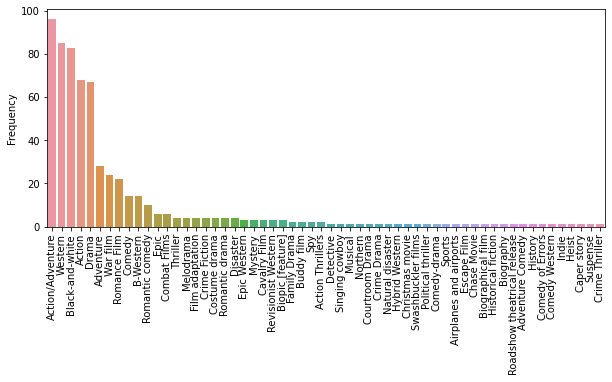

In [90]:
plt.figure(figsize=(10, 4))
sns.barplot(x=list(actor_1.keys()), y=list(actor_1.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [91]:
actor_2 = top_actors["genres_freq"].iloc[1]

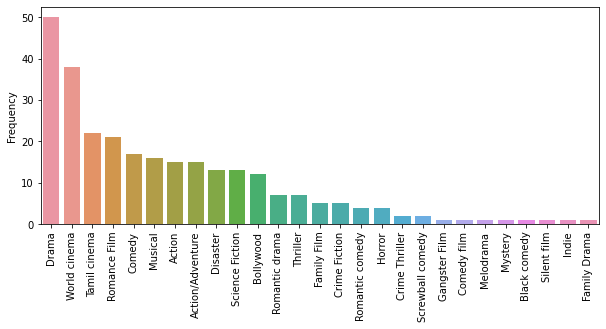

In [92]:
plt.figure(figsize=(10, 4))
sns.barplot(x=list(actor_2.keys()), y=list(actor_2.values()))
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

### Based on runtime minutes

In [93]:
runtime_per_actor = all_data[["nconst", "actor_name", "runtimeMinutes"]].copy()

In [94]:
runtime_per_actor = runtime_per_actor[runtime_per_actor["runtimeMinutes"] != "\\N"]

In [95]:
runtime_per_actor = runtime_per_actor.groupby(["nconst", "actor_name"]).agg(list).reset_index()

In [96]:
runtime_per_actor["runtimeMinutes"] = runtime_per_actor["runtimeMinutes"].apply(lambda ls: list(map(lambda elem: int(elem), ls)))

In [97]:
runtime_per_actor['len'] = runtime_per_actor['runtimeMinutes'].apply(len)
runtime_per_actor = runtime_per_actor.sort_values(by='len', ascending=False).drop(columns='len')

#### Distribution of some actors

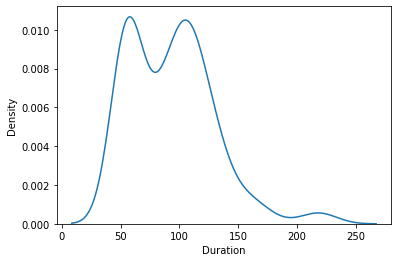

In [98]:
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[0])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()

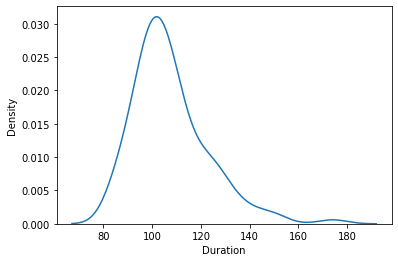

In [99]:
sns.kdeplot(runtime_per_actor["runtimeMinutes"].iloc[1])
plt.ylabel("Density")
plt.xlabel("Duration")
plt.show()